Eigentliche gute Vorhersage.
Jetzt mehr backcandles ausprobieren, hyperparamter anapassen. inputs wo 150 ist. möglichkeit weitere indikatoren oder wie auch immer.

PROBLEM: Warum das Modell einen Denkfehler hat: Das Modell lernt, dass der aktuelle closingprice nicht all zu weit vom nächsten closingpreis entfernt seien wird. Jeder vorhergesagte Wert der nah am Closingpreis des vorherigen Tages ist, sieht aus als sei er genau.
Es sieht gut aus aber man kann erkennen, dass vorhersage nur 1 Tag verzögerter tatsächlicher Wert ist.
Modell versucht Closing Preis des nächsten Tages vorherzusagen anhand vergangener Daten. Das wird für jeden Tag getestet und soll zukpünftige Werte vorherzusagen

Neuer Ansatz. Target ist der Unterschied zwischen Close der aktuellen Kerze zur nächsten Close Kerze. Es wird nun statt dem Closepreis des nächsten Tages vorherzusagen, versucht um wie viel der preis hoch oder runter geht. Wo ist der Unterschied? Nächster candle Price vs Preisbewegung.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import matplotlib.dates as mdates


In [36]:
import mlflow
import mlflow.keras

mlflow.set_experiment("Bitcoin Price Movement Prediction")


2024/05/30 12:14:14 INFO mlflow.tracking.fluent: Experiment with name 'Bitcoin Price Movement Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/WWI2021/Semester%206/Machine%20Learning%20Project/LSTM_BTC/mlruns/609496284638524771', creation_time=1717064054218, experiment_id='609496284638524771', last_update_time=1717064054218, lifecycle_stage='active', name='Bitcoin Price Movement Prediction', tags={}>

In [2]:
#.\venv\Scripts\activate

In [3]:
data = pd.read_csv("C:\WWI2021\Semester 6\Machine Learning Project\LSTM_BTC\data\BTC-USD.csv")
#data

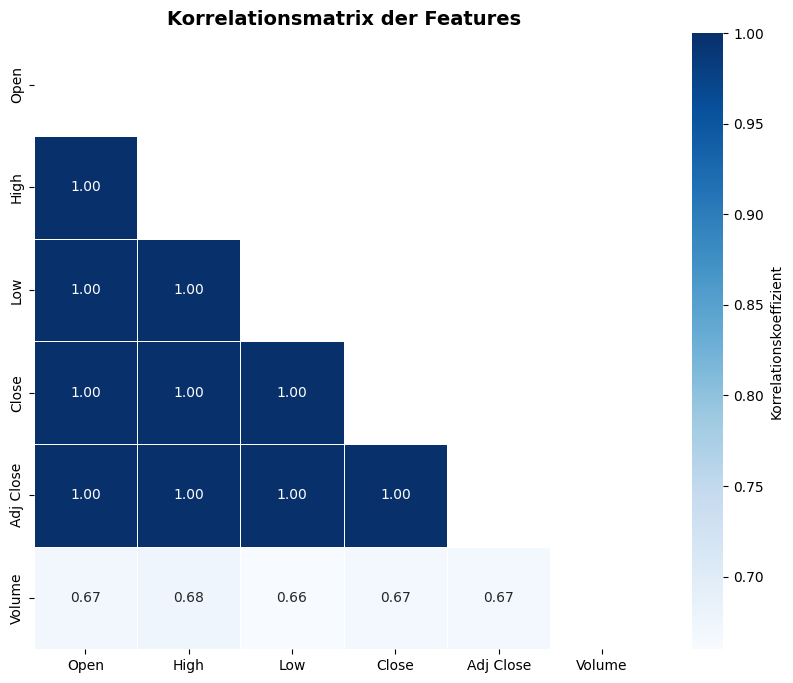

In [4]:
# Berechnen der Korrelationsmatrix
corr = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', mask=mask, cbar_kws={'label': 'Korrelationskoeffizient'},
            linewidths=0.5, linecolor='white')
plt.title('Korrelationsmatrix der Features', fontsize=14, fontweight='bold')
plt.show()

In [5]:
data['RSI']=ta.rsi(data.Close, length=15)
data['EMA20']=ta.ema(data.Close, length=20)
data['EMA100']=ta.ema(data.Close, length=100)
data['EMA150']=ta.ema(data.Close, length=150)

data

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,EMA20,EMA100,EMA150
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,NaN,NaN,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,NaN,NaN,NaN,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,NaN,NaN,NaN,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3517,2024-05-04,62891.031250,64494.957031,62599.351563,63891.472656,63891.472656,20620477992,49.568973,63492.451518,60023.934751,55814.205645
3518,2024-05-05,63892.453125,64610.890625,62955.304688,64031.132813,64031.132813,18296164805,49.895138,63543.754499,60103.285208,55923.039118
3519,2024-05-06,64038.312500,65494.902344,62746.238281,63161.949219,63161.949219,28697928697,47.832307,63507.392091,60163.852812,56018.918722
3520,2024-05-07,63162.761719,64390.457031,62285.980469,62334.816406,62334.816406,25930730982,45.897570,63395.718216,60206.842190,56102.572996


In [6]:
import pandas as pd
import ta

# Simple Moving Average (SMA)
data['SMA50'] = ta.trend.SMAIndicator(close=data['Close'], window=50).sma_indicator()



In [7]:
# Momentum Indicator
data['Momentum'] = ta.momentum.ROCIndicator(close=data['Close'], window=10).roc()

In [8]:
# Rate of Change (ROC)
data['ROC'] = ta.momentum.ROCIndicator(close=data['Close'], window=12).roc()

In [9]:
# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['Bollinger_Middle'] = bollinger.bollinger_mavg()
data['Bollinger_Upper'] = bollinger.bollinger_hband()
data['Bollinger_Lower'] = bollinger.bollinger_lband()


In [10]:
# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd.macd()

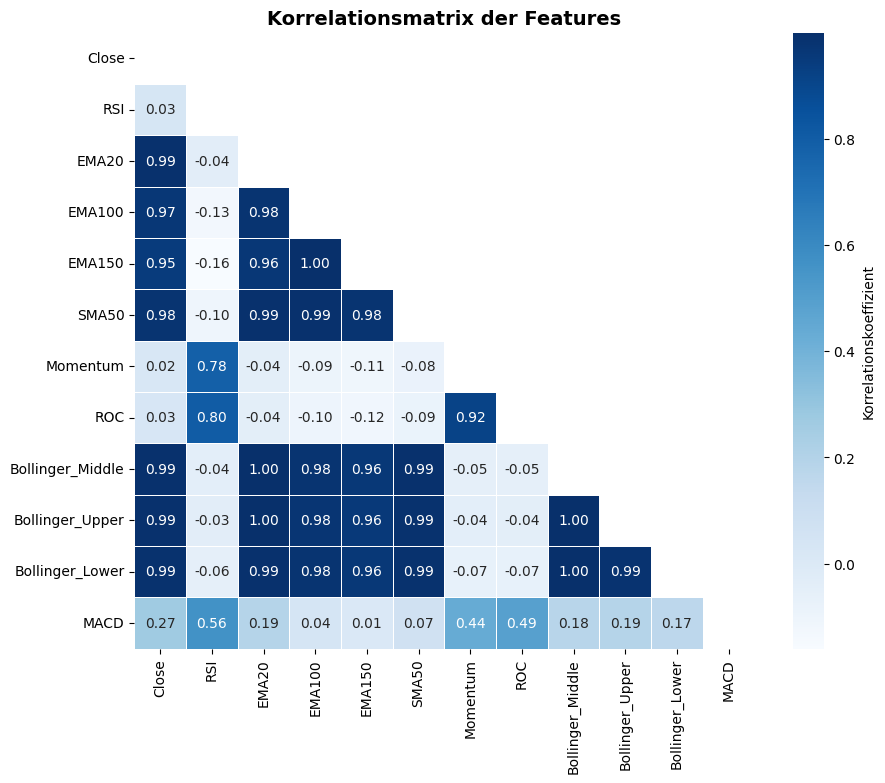

In [11]:
# Berechnen der Korrelationsmatrix
corr = data[['Close', 'RSI', 'EMA20', 'EMA100', 'EMA150', 'SMA50', 'Momentum', 'ROC', 'Bollinger_Middle', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', mask=mask, cbar_kws={'label': 'Korrelationskoeffizient'},
            linewidths=0.5, linecolor='white')
plt.title('Korrelationsmatrix der Features', fontsize=14, fontweight='bold')
plt.show()

Feature Auswahl für das Modell
Aufgrund der hohen Korrelation und der Multikollinearität macht es Sinn, redundante Features zu eliminieren und nur repräsentative Features zu behalten. Hier ist eine mögliche Auswahl:

EMA20 oder SMA50: Behalte nur eines dieser Features, da beide stark miteinander und mit dem Ziel korrelieren. Zum Beispiel: EMA20.
Bollinger_Middle: Da es stark korreliert ist und repräsentativ für die Bollinger-Bänder ist, könnte man Bollinger_Middle anstelle von Upper und Lower behalten.
MACD: Trotz der negativen Korrelation kann MACD hilfreich sein, da es eine andere Dimension der Preisbewegung darstellt.
RSI: Obwohl die Korrelation gering ist, bietet RSI ein anderes Signal, das das Modell möglicherweise ergänzt.

In [12]:
data.drop(['Date','High', 'Low', 'Adj Close', 'Volume','Open', 'EMA100', 'EMA150', 'SMA50', 'Momentum', 'ROC', 'Bollinger_Upper', 'Bollinger_Lower'], axis=1, inplace=True)

data['Previous_Close'] = data['Close'].shift(1)

data.dropna(inplace=True)

In [13]:
# Zielvariablen für die Vorhersage erstellen
data['Target'] = (data['Close'] <= data['Previous_Close']).astype(int)




In [14]:
data_clean = data
data_clean.dropna(inplace=True)
data_clean.reset_index(drop=True, inplace=True)


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Auswahl und Skalierung der relevanten Features
selected_features = ['Close', 'RSI', 'EMA20', 'Bollinger_Middle', 'MACD', 'Previous_Close']
sc = MinMaxScaler(feature_range=(0, 1))
scaled_features = sc.fit_transform(data[selected_features])


In [16]:
SEQ_LENGTH = 10 # Kann angepasst werden

def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        sequence = features[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(scaled_features, data['Target'].values, SEQ_LENGTH)


In [17]:
# Datenaufteilung: 70% Training, 20% Validierung, 10% Test
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Reshape für 1D-CNN und LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Überprüfen der neuen Formen
print(X_train.shape)  
print(X_val.shape)    
print(X_test.shape)   



(2440, 10, 6)
(697, 10, 6)
(350, 10, 6)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5064 - loss: 0.6910 - val_accuracy: 0.4821 - val_loss: 0.6968
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5494 - loss: 0.6876 - val_accuracy: 0.4849 - val_loss: 0.6971
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5392 - loss: 0.6884 - val_accuracy: 0.4792 - val_loss: 0.6945
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5725 - loss: 0.6821 - val_accuracy: 0.4806 - val_loss: 0.6942
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5433 - loss: 0.6874 - val_accuracy: 0.4878 - val_loss: 0.6951
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5453 - loss: 0.6869 - val_accuracy: 0.4907 - val_loss: 0.6937
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5394 - loss: 0.6879 - val_accuracy: 0.4706 - val_loss: 0.6948
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5491 - loss: 0.6849 - val_accuracy: 0.4849 - val_loss: 0.6943
Epo

2024/05/30 12:48:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6934581995010376
Test Accuracy: 0.5028571486473083
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix
[[115  66]
 [108  61]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      0.64      0.57       181
           1       0.48      0.36      0.41       169

    accuracy                           0.50       350
   macro avg       0.50      0.50      0.49       350
weighted avg       0.50      0.50      0.49       350



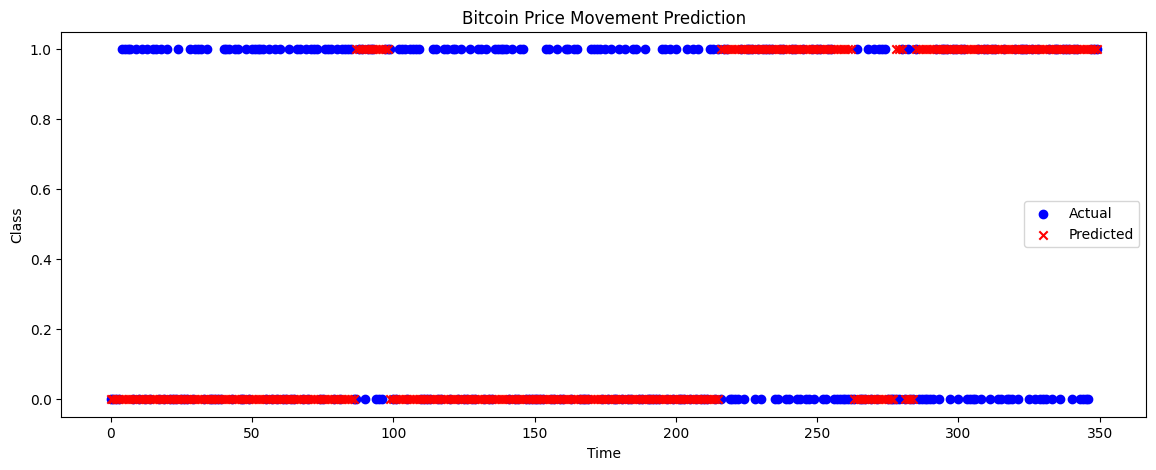

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5025 - loss: 0.6925 - val_accuracy: 0.4864 - val_loss: 0.6976
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5502 - loss: 0.6869 - val_accuracy: 0.4950 - val_loss: 0.6945
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5343 - loss: 0.6893 - val_accuracy: 0.4864 - val_loss: 0.6971
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5536 - loss: 0.6893 - val_accuracy: 0.4720 - val_loss: 0.6942
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5600 - loss: 0.6869 - val_accuracy: 0.4749 - val_loss: 0.6940
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5316 - loss: 0.6886 - val_accuracy: 0.4864 - val_loss: 0.6967
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5574 - loss: 0.6837 - val_accuracy: 0.5165 - val_loss: 0.6940
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5413 - loss: 0.6867 - val_accuracy: 0.4720 - val_loss: 0.6942
Epo

2024/05/30 12:48:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6938784122467041
Test Accuracy: 0.47428572177886963
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix
[[91 90]
 [94 75]]
Classification Report
              precision    recall  f1-score   support

           0       0.49      0.50      0.50       181
           1       0.45      0.44      0.45       169

    accuracy                           0.47       350
   macro avg       0.47      0.47      0.47       350
weighted avg       0.47      0.47      0.47       350



<Figure size 640x480 with 0 Axes>

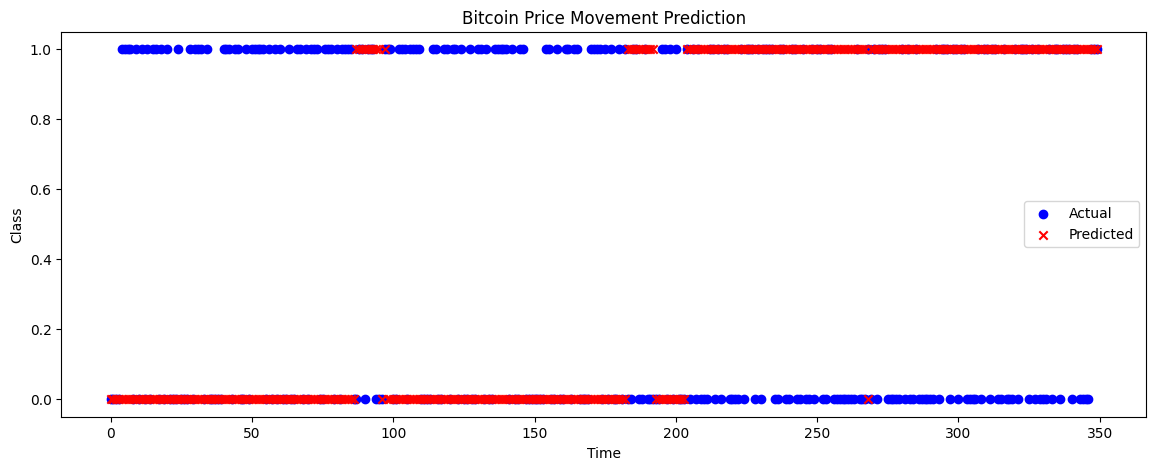

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5458 - loss: 0.6911 - val_accuracy: 0.4864 - val_loss: 0.6959
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5381 - loss: 0.6894 - val_accuracy: 0.4806 - val_loss: 0.6949
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5396 - loss: 0.6898 - val_accuracy: 0.4792 - val_loss: 0.6966
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5413 - loss: 0.6881 - val_accuracy: 0.4792 - val_loss: 0.6943
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5477 - loss: 0.6876 - val_accuracy: 0.4778 - val_loss: 0.6937
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5474 - loss: 0.6855 - val_accuracy: 0.4921 - val_loss: 0.6939
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5443 - loss: 0.6862 - val_accuracy: 0.4864 - val_loss: 0.6953
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5406 - loss: 0.6896 - val_accuracy: 0.4864 - val_loss: 0.6943
Epo

2024/05/30 12:49:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6928243637084961
Test Accuracy: 0.522857129573822
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix
[[156  25]
 [142  27]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      0.86      0.65       181
           1       0.52      0.16      0.24       169

    accuracy                           0.52       350
   macro avg       0.52      0.51      0.45       350
weighted avg       0.52      0.52      0.45       350



<Figure size 640x480 with 0 Axes>

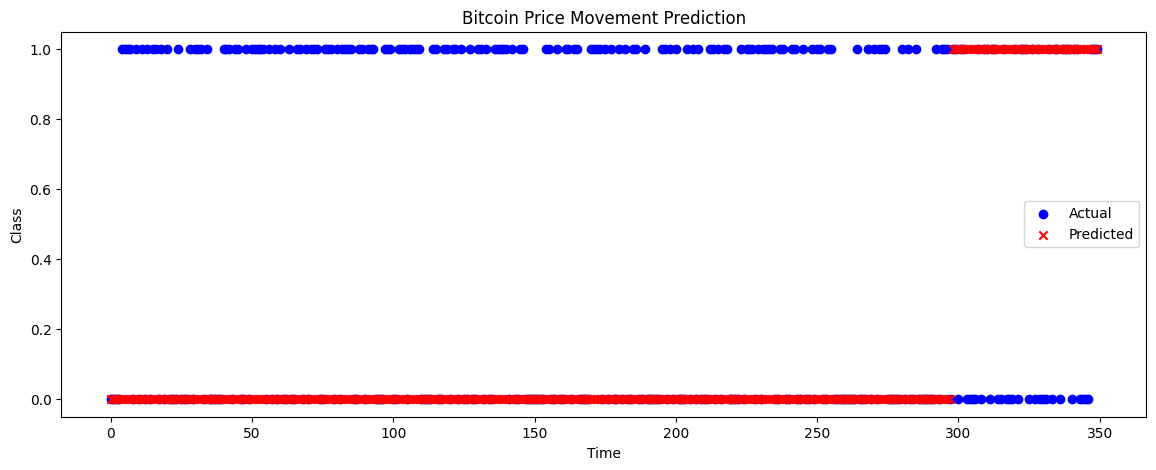

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5226 - loss: 0.6919 - val_accuracy: 0.4864 - val_loss: 0.6966
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5429 - loss: 0.6869 - val_accuracy: 0.4950 - val_loss: 0.6950
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5263 - loss: 0.6920 - val_accuracy: 0.4978 - val_loss: 0.6952
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5274 - loss: 0.6907 - val_accuracy: 0.4921 - val_loss: 0.6945
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5313 - loss: 0.6881 - val_accuracy: 0.4935 - val_loss: 0.6953
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5427 - loss: 0.6892 - val_accuracy: 0.4864 - val_loss: 0.6952
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5528 - loss: 0.6861 - val_accuracy: 0.4821 - val_loss: 0.6939
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5550 - loss: 0.6861 - val_accuracy: 0.4720 - val_loss: 0.6937
Epo

2024/05/30 12:49:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6933860778808594
Test Accuracy: 0.488571435213089
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix
[[99 82]
 [97 72]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       181
           1       0.47      0.43      0.45       169

    accuracy                           0.49       350
   macro avg       0.49      0.49      0.49       350
weighted avg       0.49      0.49      0.49       350



<Figure size 640x480 with 0 Axes>

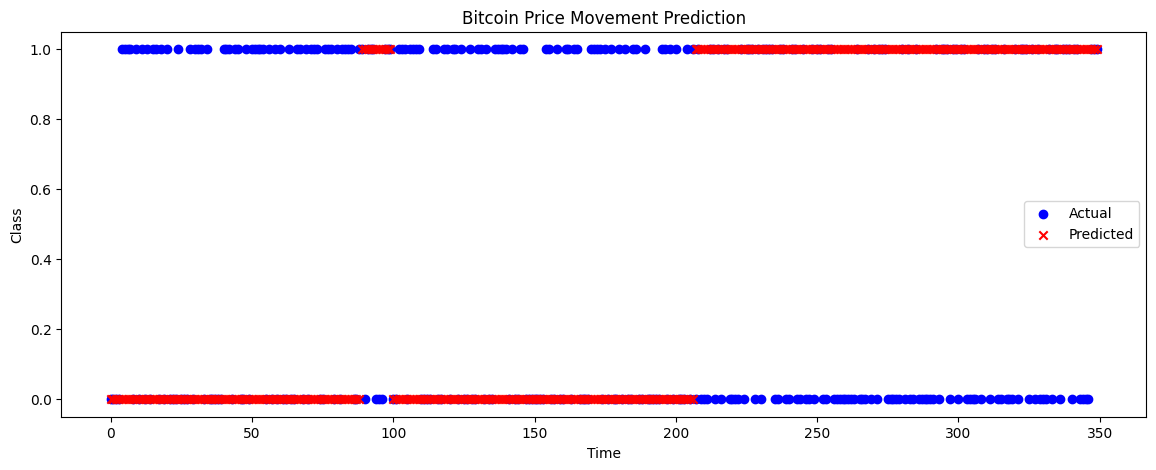

<Figure size 640x480 with 0 Axes>

In [37]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for lr in learning_rates:
    with mlflow.start_run():
        mlflow.log_param("learning_rate", lr)

        optimizer = Adam(learning_rate=lr)

        # Modellarchitektur definieren
        model = Sequential()

        # 1D Convolutional Layer
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, len(selected_features))))
        model.add(MaxPooling1D(pool_size=2))

        # LSTM Layer (ohne Flatten)
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dropout(0.2))

        # Dense Layer für binäre Klassifikation
        model.add(Dense(units=1, activation='sigmoid'))

        # Lernrate festlegen
        learning_rate = 0.001  # Beispielwert, passe ihn nach Bedarf an

        # Optimierer mit der gewünschten Lernrate initialisieren
        optimizer = Adam(learning_rate=learning_rate)

        # Modell kompilieren
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Modell trainieren
        history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))
        # Modell bewerten
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Test Loss: {loss}')
        print(f'Test Accuracy: {accuracy}')

        # MLflow-Logging
        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.keras.log_model(model, "model")

        # Vorhersagen treffen und Wahrscheinlichkeiten in binäre Werte umwandeln
        predictions = (model.predict(X_test) > 0.5).astype(int)

        # Confusion Matrix
        cm = confusion_matrix(y_test, predictions)
        print('Confusion Matrix')
        print(cm)

        # Classification Report
        cr = classification_report(y_test, predictions)
        print('Classification Report')
        print(cr)

        # Plot der Ergebnisse
        plt.figure(figsize=(14, 5))
        plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', marker='o')
        plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted', marker='x')
        plt.title('Bitcoin Price Movement Prediction')
        plt.xlabel('Time')
        plt.ylabel('Class')
        plt.legend()
        plt.show()
        
        # Save plot
        plt.savefig("plot.png")
        mlflow.log_artifact("plot.png")

        # Log confusion matrix and classification report
        with open("confusion_matrix.txt", "w") as f:
            f.write(str(cm))
        mlflow.log_artifact("confusion_matrix.txt")

        with open("classification_report.txt", "w") as f:
            f.write(cr)
        mlflow.log_artifact("classification_report.txt")




In [20]:
# Vorhersagen treffen
predictions = (model.predict(X_test) > 0.5).astype(int)

# Modell bewerten
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.4938 - loss: 0.6940
Test Loss: 0.6936560273170471
Test Accuracy: 0.49142858386039734


In [21]:
# Vorhersagen treffen
predictions = (model.predict(X_test) > 0.5).astype(int)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


In [ ]:
# Modell bewerten
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# MLflow-Logging
mlflow.log_metric("loss", loss)
mlflow.log_metric("accuracy", accuracy)
mlflow.keras.log_model(model, "model")


Confusion Matrix
[[109  72]
 [106  63]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       181
           1       0.47      0.37      0.41       169

    accuracy                           0.49       350
   macro avg       0.49      0.49      0.48       350
weighted avg       0.49      0.49      0.48       350



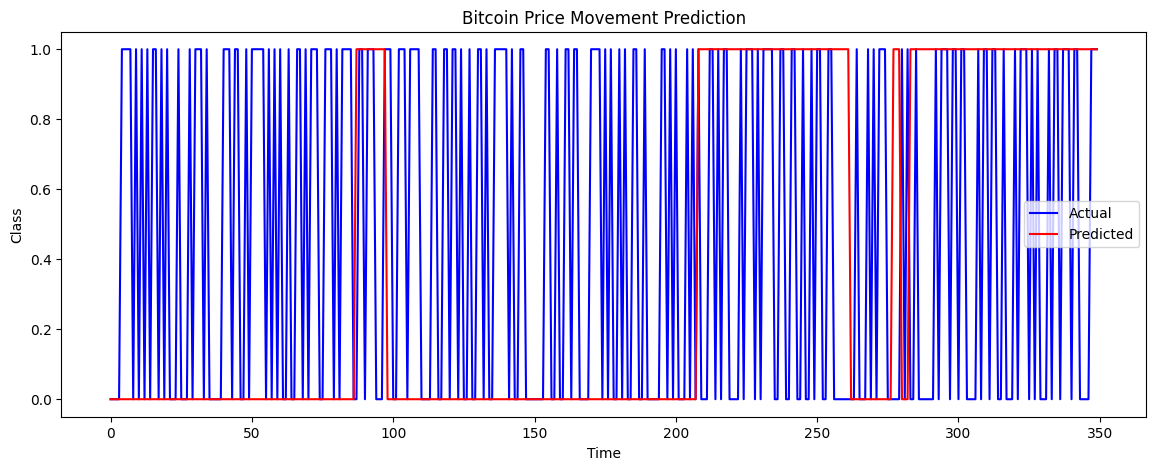

In [22]:
# Ergebnisse visualisieren
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cm)

# Classification Report
cr = classification_report(y_test, predictions)
print('Classification Report')
print(cr)

# Plot der Ergebnisse
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Bitcoin Price Movement Prediction')
plt.xlabel('Time')
plt.ylabel('Class')
plt.legend()
plt.show()

Confusion Matrix
[[109  72]
 [106  63]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       181
           1       0.47      0.37      0.41       169

    accuracy                           0.49       350
   macro avg       0.49      0.49      0.48       350
weighted avg       0.49      0.49      0.48       350



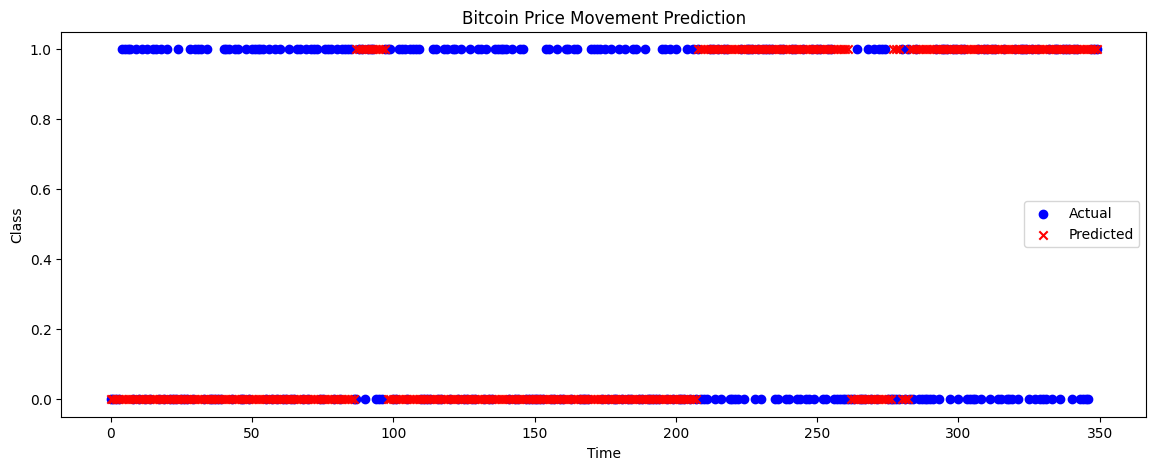

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cm)

# Classification Report
cr = classification_report(y_test, predictions)
print('Classification Report')
print(cr)

# Plot der Ergebnisse
plt.figure(figsize=(14, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', marker='o')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted', marker='x')
plt.title('Bitcoin Price Movement Prediction')
plt.xlabel('Time')
plt.ylabel('Class')
plt.legend()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


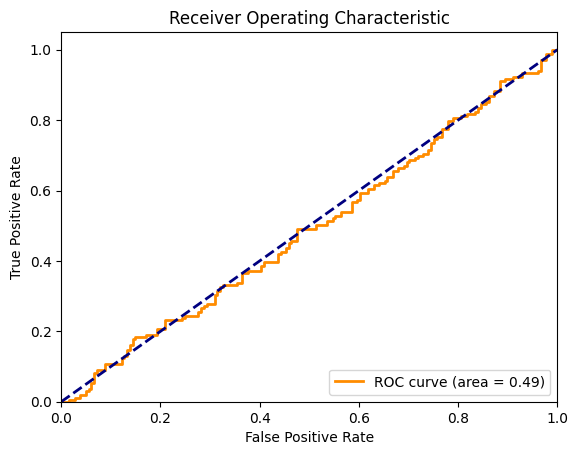

In [28]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


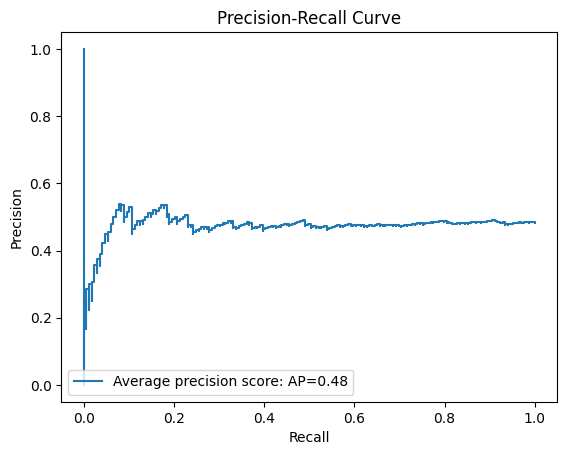

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_prob = model.predict(X_test).ravel()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, where='post', label='Average precision score: AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


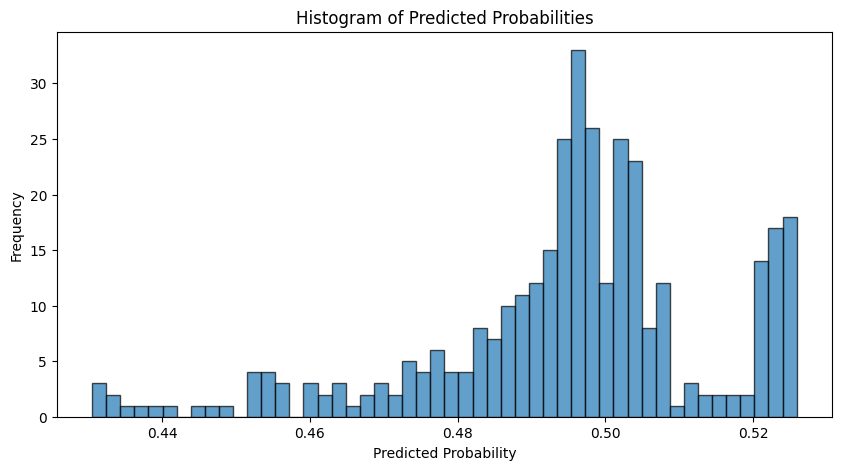

In [30]:
y_pred_prob = model.predict(X_test).ravel()

plt.figure(figsize=(10, 5))
plt.hist(y_pred_prob, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


Optimierungsmöglichkeiten für wenn Lifecycle Management Tool eingeführt ist:

Wenn Sie die Preisbewegung (zum Beispiel die Richtung der Preisänderung oder die prozentuale Änderung) anstelle des tatsächlichen Preises vorhersagen und feststellen, dass die Leistung des Modells nicht zufriedenstellend ist, gibt es mehrere Ansätze, um die Vorhersagequalität zu verbessern. Hier sind einige Strategien, die Sie in Betracht ziehen können:


### 2. **Modellarchitektur anpassen**
- **Anzahl der LSTM-Einheiten ändern**: Erhöhen oder verringern Sie die Anzahl der Neuronen in den LSTM-Schichten, um zu sehen, ob dies die Modellleistung beeinflusst.
- **Tiefe des Netzwerks**: Fügen Sie mehrere LSTM-Schichten hinzu, um ein tieferes Netzwerk zu erstellen, das möglicherweise komplexere Muster erfassen kann.
- **Dropout hinzufügen**: Um Overfitting zu vermeiden, fügen Sie Dropout-Schichten hinzu, die helfen können, die Generalisierbarkeit des Modells zu verbessern.

### 3. **Hyperparameter optimieren**
- **Lernrate anpassen**: Experimentieren Sie mit unterschiedlichen Lernraten und anderen Optimierungsparametern.
- **Batch-Größe und Epochenzahl**: Das Ändern der Batch-Größe und der Anzahl der Epochen kann erhebliche Auswirkungen auf das Trainingsergebnis haben.
- **Regularisierung anwenden**: Experimentieren Sie mit verschiedenen Arten von Regularisierungen (L1, L2), um das Overfitting zu kontrollieren.

### 4. **Verlustfunktion anpassen**
- **Andere Verlustfunktionen ausprobieren**: Wenn Sie die Richtung der Preisbewegung vorhersagen, könnte eine binäre Kreuzentropie (wenn es sich um eine Klassifikationsaufgabe handelt) oder eine benutzerdefinierte Verlustfunktion, die speziell für Ihr Vorhersageziel entwickelt wurde, nützlich sein.

### 5. **Trainingstechniken überprüfen**
- **Frühzeitiges Beenden**: Verwenden Sie Early Stopping, um das Training zu beenden, wenn sich die Validierungsleistung nicht mehr verbessert.
- **Daten-Shuffling und -Partitionierung**: Stellen Sie sicher, dass Ihre Trainings-, Validierungs- und Testdatensätze richtig partitioniert und während des Trainings effektiv gemischt werden.

### 6. **Evaluation und Benchmarking**
- **Cross-Validation verwenden**: Statt einer einfachen Train-Test-Split kann Cross-Validation eine robustere Evaluation der Modellleistung bieten.
- **Leistungsmetriken**: Überprüfen Sie, ob Sie die richtigen Metriken für die Bewertung des Modells verwenden. Für Klassifikationsaufgaben sind Genauigkeit, F1-Score, ROC-AUC usw. relevant.

Diese Ansätze bieten verschiedene Wege, die Modellleistung zu verbessern und sollten je nach spezifischem Szenario und den Ergebnissen der initialen Modellbewertungen angepasst werden.